# Introduction

This analysis aims to identify the most significant factors influencing people's reviews on luggage loss issues and how these factors impact the overall rating of airlines. To address this, I built a linear regression model to predict the overall rating. By examining the coefficients of this model, we can determine how each factor affects the results.

Additionally, another approach involves building a classification model to predict sentiment labels—positive, negative, or neutral. Through this model, we can also identify the most significant factors influencing sentiment.

# Methonds

## Step 1 : Loading Data

In [4]:
import pandas as pd

df = pd.read_csv('Gold_20250327_AirlineReviews_Sentiment_Image_Summary.csv')
print(df[['sentiment_label', 'sentiment_score']].head(3))

  sentiment_label  sentiment_score
0        positive         0.918486
1        negative         0.569241
2         neutral         0.542810


In [5]:
print(df.columns)

Index(['RowId', 'Airline_Name', 'Review_Title', 'Review_Date', 'Verified',
       'Review', 'Top_Review_Image_Url', 'Aircraft', 'Type_Of_Traveller',
       'Seat_Type', 'Route', 'Date_Flown', 'Seat_Comfort',
       'Cabin_Staff_Service', 'Food_Beverages', 'Ground_Service',
       'Inflight_Entertainment', 'Wifi_Connectivity', 'Value_For_Money',
       'Recommended', 'Id', 'sentiment_label', 'sentiment_score',
       'img_resnet50_score', 'img_resnet50_label', 'img_blip_caption',
       'img_clip_embedding', 'img_caption_clip_embedding',
       'img_resnet50label_clip_embedding', 'img_vs_caption_similarity',
       'img_caption_vs_resnetlabel_similarity', 'Overall_Rating', 'Summary'],
      dtype='object')


## Step 2: Examining the Relationship Between Overall Rating and Sentiment Label

Correlation between Overall Rating and Sentiment Label: 0.78


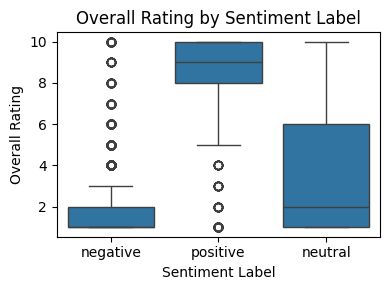

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt

label_mapping = {'negative': 0, 'neutral': 1, 'positive': 2}  # Example
df['sentiment_label_encoded'] = df['sentiment_label'].map(label_mapping)

correlation = df['Overall_Rating'].corr(df['sentiment_label_encoded'])
print(f"Correlation between Overall Rating and Sentiment Label: {correlation:.2f}")

df['Overall_Rating'] = pd.to_numeric(df['Overall_Rating'], errors='coerce')

plt.figure(figsize=(4, 3))
sns.boxplot(data=df, x='sentiment_label', y='Overall_Rating')
plt.title('Overall Rating by Sentiment Label')
plt.xlabel('Sentiment Label')
plt.ylabel('Overall Rating')
plt.tight_layout()
plt.show()

This picture shows that positive reviews have a higher overall rating, ranging from 7 to 10, while negative reviews have a lower overall rating, ranging from 1 to 2. This suggests that sentiment labels can also be measured by overall rating. Furthermore, this relationship is supported by the correlation coefficient between Overall Rating and Sentiment Label, which is 0.8, indicating a strong positive correlation.

## Step3: Using P-value finding significant features

In [29]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
import statsmodels.api as sm


features = [
    'Seat_Comfort', 'Cabin_Staff_Service', 'Food_Beverages',
    'Ground_Service', 'Inflight_Entertainment', 'Wifi_Connectivity',
    'Value_For_Money', 'Type_Of_Traveller', 'Seat_Type', 'Verified', 'Airline_Name'
]
target = 'Overall_Rating'

df = df.dropna(subset=[target] + features)

X = df[features]
y = df[target].values  # Convert to numpy array explicitly

categorical_cols = ['Type_Of_Traveller', 'Seat_Type', 'Verified', 'Airline_Name']
numerical_cols = [col for col in features if col not in categorical_cols]

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_cols),
        ('num', StandardScaler(), numerical_cols)
    ])

X_processed = preprocessor.fit_transform(X)

cat_encoder = preprocessor.named_transformers_['cat']
cat_features = cat_encoder.get_feature_names_out(categorical_cols)
all_features = np.concatenate([cat_features, numerical_cols])

X_processed_df = pd.DataFrame(X_processed, columns=all_features).astype(float)

X_processed_df = sm.add_constant(X_processed_df)
y = y.astype(float)

model = sm.OLS(y, X_processed_df).fit()

significant_features = model.pvalues[model.pvalues < 0.05].index.tolist()
print("\nSignificant features (p < 0.05):", significant_features)


Significant features (p < 0.05): ['Seat_Comfort', 'Cabin_Staff_Service', 'Food_Beverages', 'Ground_Service', 'Wifi_Connectivity', 'Value_For_Money']


By performing an Ordinary Least Squares (OLS) regression model, we identified six significant features (p < 0.05) using a t-test: 'Seat_Comfort,' 'Cabin_Staff_Service,' 'Food_Beverages,' 'Ground_Service,' 'Wifi_Connectivity,' and 'Value_For_Money.' I will use these six features to build both a linear regression model and a classification model.

**Computing correlations between each pair of features.**

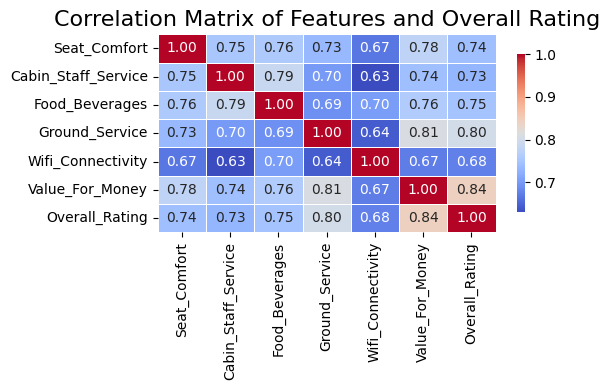

In [16]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Compute correlations
correlation_matrix = df[['Seat_Comfort', 'Cabin_Staff_Service', 'Food_Beverages', 
                         'Ground_Service', 'Wifi_Connectivity', 'Value_For_Money', 'Overall_Rating']].corr()

# Sort the correlation with 'Overall_Rating' in descending order
sorted_correlation = correlation_matrix['Overall_Rating'].sort_values(ascending=False)

# Print the sorted correlation values
# print(sorted_correlation)

# Plot the correlation matrix as a heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5, cbar_kws={"shrink": .8})

# Title and adjustments
plt.title('Correlation Matrix of Features and Overall Rating', fontsize=16)
plt.tight_layout()

# Display the heatmap
plt.show()



**Checking VIF**

In [11]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Load the dataset
# df = pd.read_csv("your_data.csv")

# Select relevant features and target
features = ['Value_For_Money', 'Ground_Service', 'Food_Beverages', 'Seat_Comfort', 'Cabin_Staff_Service', 'Wifi_Connectivity']
target = 'Overall_Rating'

# Clean data
df = df.dropna(subset=[target] + features)

# Separate features and target
X = df[features]
y = df[target]

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Check multicollinearity with VIF
vif_data = pd.DataFrame()
vif_data['feature'] = features
vif_data['VIF'] = [variance_inflation_factor(X_scaled, i) for i in range(len(features))]

# Print VIF values
print(vif_data)


               feature       VIF
0      Value_For_Money  4.167547
1       Ground_Service  3.276327
2       Food_Beverages  3.704536
3         Seat_Comfort  3.450402
4  Cabin_Staff_Service  3.291569
5    Wifi_Connectivity  2.276986


From the heatmap of the correlation matrix, we can conclude that the correlation coefficients between some feature pairs are very high, suggesting potential multicollinearity. To verify this, I checked for multicollinearity using the Variance Inflation Factor (VIF). The results show that none of the features have a VIF value greater than 10, indicating that multicollinearity is not a concern.

## Step4: Linear Regression

In [18]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Load the dataset (assuming df is already loaded)
# df = pd.read_csv("Airline_review.csv")

# Define features and target
features = ['Seat_Comfort', 'Cabin_Staff_Service', 'Food_Beverages', 
            'Ground_Service', 'Wifi_Connectivity', 'Value_For_Money']
target = 'Overall_Rating'

# Drop rows with missing values in selected columns
df = df.dropna(subset=[target] + features)

# Separate features and target
X = df[features]
y = df[target]

# Split data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [20]:
# Step 1: Evaluate the Linear Regression model
from sklearn.metrics import mean_squared_error, r2_score

reg = LinearRegression()
reg.fit(X_train, y_train)

# Predict on the test data
y_pred = reg.predict(X_test)

# Calculate R-squared and MSE
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print(f"Linear Regression - R2: {r2:.4f}, MSE: {mse:.4f}")

# Step 2: Try Ridge Regression (L2 Regularization)
from sklearn.linear_model import Ridge

ridge_reg = Ridge(alpha=1.0)  # Regularization strength
ridge_reg.fit(X_train, y_train)

# Evaluate Ridge Regression on test data
y_pred_ridge = ridge_reg.predict(X_test)

r2_ridge = r2_score(y_test, y_pred_ridge)
mse_ridge = mean_squared_error(y_test, y_pred_ridge)

print(f"Ridge Regression - R2: {r2_ridge:.4f}, MSE: {mse_ridge:.4f}")

# Step 3: Try Lasso Regression (L1 Regularization)
from sklearn.linear_model import Lasso

lasso_reg = Lasso(alpha=0.1)  # Regularization strength
lasso_reg.fit(X_train, y_train)

# Evaluate Lasso Regression on test data
y_pred_lasso = lasso_reg.predict(X_test)

r2_lasso = r2_score(y_test, y_pred_lasso)
mse_lasso = mean_squared_error(y_test, y_pred_lasso)

print(f"Lasso Regression - R2: {r2_lasso:.4f}, MSE: {mse_lasso:.4f}")

Linear Regression - R2: 0.7861, MSE: 2.0799
Ridge Regression - R2: 0.7861, MSE: 2.0799
Lasso Regression - R2: 0.7853, MSE: 2.0869


I performed Linear Regression, Ridge Regression, and Lasso Regression. The results show that Linear Regression and Ridge Regression have the same R-squared and MSE, while Lasso Regression has a slightly lower R-squared (0.7853) and a slightly higher MSE (2.0869). Based on these results, I chose Linear Regression as the final model.

In [13]:
from sklearn.linear_model import LinearRegression

reg = LinearRegression()
reg.fit(X_train, y_train)

feature_coefficients = dict(zip(X_train.columns, reg.coef_))

# Print coefficients with feature names
print("Feature Coefficients:")
for feature, coef in feature_coefficients.items():
    print(f"{feature}: {coef:.4f}")


Feature Coefficients:
Seat_Comfort: 0.0900
Cabin_Staff_Service: 0.1877
Food_Beverages: 0.2567
Ground_Service: 0.5498
Wifi_Connectivity: 0.1760
Value_For_Money: 0.8452


**Key Observations** <br>
Value for Money (0.8452) has the strongest impact <br>
It has the highest coefficient, meaning passengers value affordability the most when rating their overall experience. <br>

Ground Service (0.5498) is also significant <br>
This suggests that check-in, boarding, and airport assistance play a major role in satisfaction. <br>

Food & Beverages (0.2567) and Cabin Staff Service (0.1877) matter, but less than Value for Money <br>
While food and service quality impact ratings, they are not as influential as cost-effectiveness. <br>

Seat Comfort (0.0900) and Wifi Connectivity (0.1760) have the least impact <br>
While important, these factors don’t significantly alter Overall_Rating compared to Value for Money or Ground Service. <br>

## Step 5: Sentiment Label Classification

Random Forest - Classification Report:
              precision    recall  f1-score   support

    negative       0.87      0.96      0.92       844
     neutral       0.16      0.04      0.06       125
    positive       0.81      0.83      0.82       227

    accuracy                           0.84      1196
   macro avg       0.61      0.61      0.60      1196
weighted avg       0.79      0.84      0.81      1196


Random Forest - Confusion Matrix:
[[813  12  19]
 [ 96   5  24]
 [ 24  15 188]]


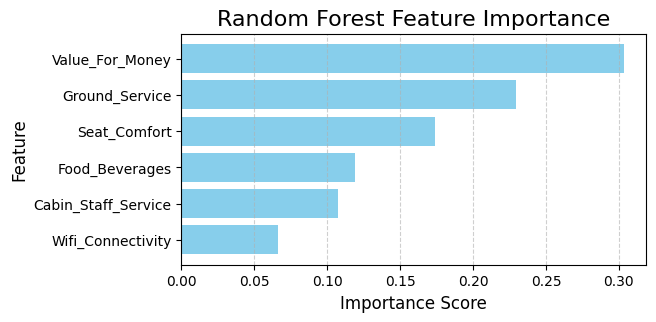

In [23]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Load the dataset
# df = pd.read_csv("Airline_review.csv")  # Update with your file path

# Select relevant features and target
features = ['Seat_Comfort', 'Cabin_Staff_Service', 'Food_Beverages', 
            'Ground_Service', 'Wifi_Connectivity', 'Value_For_Money']
target = 'sentiment_label'

# Clean data (remove rows with missing values)
df = df.dropna(subset=[target] + features)

# Separate features (X) and target (y)
X = df[features]
y = df[target]

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Train Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predictions and evaluation
rf_preds = rf_model.predict(X_test)
print("Random Forest - Classification Report:")
print(classification_report(y_test, rf_preds))

print("\nRandom Forest - Confusion Matrix:")
print(confusion_matrix(y_test, rf_preds))

# Feature importance analysis
rf_feature_importance = rf_model.feature_importances_
feature_importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': rf_feature_importance
}).sort_values(by='Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(6, 3))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.xlabel('Importance Score', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.title('Random Forest Feature Importance', fontsize=16)
plt.gca().invert_yaxis()  # Show highest importance at the top
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.show()

# Conclusion

Improving "Value for Money" should be a priority since it has the highest influence on customer satisfaction. <br>
Enhancing Ground Services (check-in, boarding, baggage handling) can greatly boost ratings. <br>
WiFi & Seat Comfort have lower impacts, meaning improving these might not drastically increase ratings. <br>